[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/trim-filter-messages.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239435-lesson-4-trim-and-filter-messages)

In [49]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai

In [50]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [51]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

In [52]:
from operator import add
from typing import Annotated, TypedDict

class Fact(TypedDict):
    fact: str
    understanding: str
    support_facts: Annotated[list[str], add]
    refuted_facts: Annotated[list[str], add]
    final_result: str

In [53]:
from langchain_openai import ChatOpenAI
gpt4o_chat = ChatOpenAI(model="gpt-4o", temperature=0)

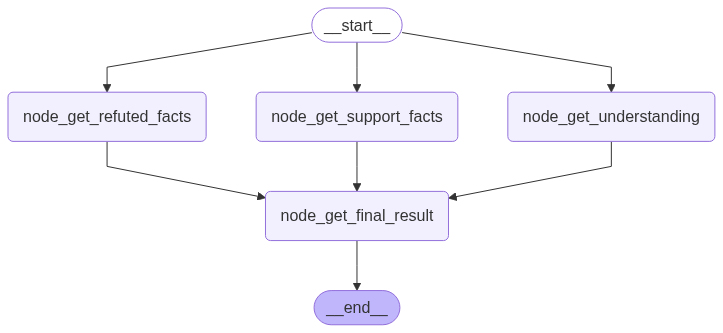

In [54]:
import random
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage

def node_get_understanding(fact: Fact) -> Fact:
    print("---Node get understanding---")
    msg = HumanMessage(content=f"What does ones imply when saying `{fact['fact']}`?", name="User")

    # Message list
    messages = [msg]

    # Invoke the model with a list of messages 
    response = gpt4o_chat.invoke(messages)
    return {
        "fact": fact,
        "support_facts": [],
        "refuted_facts": [],
        "understanding": response.content
    }

def node_get_support_facts(fact: Fact) -> Fact:
    print("---Node get support facts---")
    msg = HumanMessage(content=f"What are the facts that support the statement `{fact['fact']}`?", name="User")
    messages = [msg]
    response = gpt4o_chat.invoke(messages)
    return {
        "support_facts": [response.content],
    }

def node_get_refuted_facts(fact: Fact) -> Fact:
    print("---Node get refuted facts---")
    msg = HumanMessage(content=f"What are the facts that refute the statement `{fact['fact']}`?", name="User")
    messages = [msg]
    response = gpt4o_chat.invoke(messages)
    return {
        "refuted_facts": [response.content],
    }

def node_get_final_result(fact: Fact) -> Fact:
    print("---Node get final result---")
    msg = HumanMessage(content=f"""
                       What is the final result of the fact check for the statement `{fact['fact']}`?
                            The support facts are: {fact['support_facts']}
                            The refuted facts are: {fact['refuted_facts']}
                            The understanding is: {fact['understanding']}
                    """, name="User")
    messages = [msg]
    response = gpt4o_chat.invoke(messages)
    return {
        "final_result": response.content
    }

# Build graph
builder = StateGraph(Fact)
builder.add_node("node_get_understanding", node_get_understanding)
builder.add_node("node_get_support_facts", node_get_support_facts)
builder.add_node("node_get_refuted_facts", node_get_refuted_facts)
builder.add_node("node_get_final_result", node_get_final_result)

# Logic
builder.add_edge(START, "node_get_understanding")
builder.add_edge(START, "node_get_support_facts")
builder.add_edge(START, "node_get_refuted_facts")
builder.add_edge("node_get_understanding", "node_get_final_result")
builder.add_edge("node_get_support_facts", "node_get_final_result")
builder.add_edge("node_get_refuted_facts", "node_get_final_result")
builder.add_edge("node_get_final_result", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [56]:
graph.invoke({"fact": "Donal Trump is the US president after Obama"})

---Node get refuted facts------Node get support facts---

---Node get understanding---
---Node get final result---


{'fact': {'fact': 'Donal Trump is the US president after Obama',
  'support_facts': [],
  'refuted_facts': []},
 'understanding': 'When someone says "Donald Trump is the US president after Obama," they are indicating that Donald Trump succeeded Barack Obama as the President of the United States. Barack Obama served as the 44th president from January 20, 2009, to January 20, 2017. Donald Trump then became the 45th president, serving from January 20, 2017, to January 20, 2021. The statement is simply noting the chronological order of their presidencies.',
 'support_facts': ['The statement "Donald Trump is the US president after Obama" is supported by the following facts:\n\n1. **Barack Obama\'s Presidency**: Barack Obama served as the 44th President of the United States from January 20, 2009, to January 20, 2017. He completed two terms in office.\n\n2. **2016 Presidential Election**: Donald Trump ran as the Republican candidate in the 2016 presidential election. He won the election again